# Project description
* We've been provided with data from the analytical department of Yandex.Afisha. Our first task is to help optimize marketing expenses.
>  We have:
* Server logs with data on Yandex.Afisha visits from June 2017 through May 2018
* Dump file with all orders for the period
* Marketing expenses statistics
> We are going to study:
* How people use the product, through traffic ,retention and other metrics.
* When they start to buy, calculating conversion rate.
* How much money each customer brings, through lifetime value metric.
* When they pay off ,with calculating ROMI(return of investment metric).

## Import libraries , import the data and prepare it for analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from termcolor import colored
import matplotlib as mpl
plt.style.use('seaborn-whitegrid')

In [3]:
try:
    visits=pd.read_csv('visits_log_us.csv',\
                   dtype={'Device':'category','Source Id':'category'},parse_dates=['End Ts','Start Ts'])
    orders=pd.read_csv('orders_log_us.csv',parse_dates=['Buy Ts'])
    expenses=pd.read_csv('costs_us.csv',dtype={'source_id':'category'},parse_dates=['dt'])
except:
    visits=pd.read_csv('/datasets/visits_log_us.csv',\
                   dtype={'Device':'category','Source Id':'category'},parse_dates=['End Ts','Start Ts'])
    orders=pd.read_csv('/datasets/orders_log_us.csv',parse_dates=['Buy Ts'])
    expenses=pd.read_csv('/datasets/costs_us.csv',dtype={'source_id':'category'},parse_dates=['dt'])

* We optimized the data during the loading by converting into the proper data type some the variables is order to reduce the size of the data for memory purposes.

In [3]:
#Look at the data:
print(visits.info(memory_usage='deep'))
print('================================')
print(orders.info())
print('================================')
print(expenses.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null category
End Ts       359400 non-null datetime64[ns]
Source Id    359400 non-null category
Start Ts     359400 non-null datetime64[ns]
Uid          359400 non-null uint64
dtypes: category(2), datetime64[ns](2), uint64(1)
memory usage: 8.9 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null datetime64[ns]
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null category
dt           2542 non-null datetime64[ns]
costs        2542 non-null float64
dtypes: category(1), datetime64[ns](1), float64(1)
memory usage: 42.7 KB
None


In [4]:
visits.describe(include='all')

,Device,End Ts,Source Id,Start Ts,Uid
count,359400,359400,359400,359400,3.594000e+05
unique,2,224760,9,224303,NaN
top,desktop,2017-11-24 16:51:00,4,2017-11-24 16:06:00,NaN
freq,262567,23,101794,19,NaN
first,NaN,2017-06-01 00:02:00,NaN,2017-06-01 00:01:00,NaN
last,NaN,2018-06-01 01:26:00,NaN,2018-05-31 23:59:00,NaN
mean,NaN,NaN,NaN,NaN,9.202557e+18
std,NaN,NaN,NaN,NaN,5.298433e+18
min,NaN,NaN,NaN,NaN,1.186350e+13
25%,NaN,NaN,NaN,NaN,4.613407e+18


In [5]:
display(visits.head())
display(orders.head())
expenses.head()

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


* We can see that the users come from two different devices with most frequent device being the desktop with 262567 sessions out of 359400 in total.
* Users come from 9 different traffic sources with the most observed source 4.101794 visits out of 359400 came from this traffic source.
* We see that the most frequent date of our logs is 2017-11-24, which makes sense since that day is the Black Friday for the year 2017, and also the time period of our recorded logs is from 2017-06-01 until 2018-06-01.
* For memory efficiency we will covnert the numerical attributes revenue and costs to float16.

## Data preprocessing

In [4]:
#check for NANs
print(visits.isnull().sum())
print('---------------------')
print(orders.isnull().sum())
print('---------------------')
print(expenses.isnull().sum())

Device       0
End Ts       0
Source Id    0
Start Ts     0
Uid          0
dtype: int64
---------------------
Buy Ts     0
Revenue    0
Uid        0
dtype: int64
---------------------
source_id    0
dt           0
costs        0
dtype: int64


In [5]:
# check or duplicates
print(visits.duplicated().sum())
print('-------------------------')
print(orders.duplicated().sum())
print('-------------------------')
print(expenses.duplicated().sum())

0
-------------------------
0
-------------------------
0


In [6]:
# convert name columns to lower letter
dfs=[visits,orders,expenses]
for i in dfs:
    i.columns=i.columns.str.replace(' ','_').str.lower()

In [7]:
#convert revenue and costs to float16
orders['revenue']=orders['revenue'].astype('float32')
expenses['costs']=expenses['costs'].astype('float32')

In [8]:
print(orders.info(),'\n',expenses.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
buy_ts     50415 non-null datetime64[ns]
revenue    50415 non-null float32
uid        50415 non-null uint64
dtypes: datetime64[ns](1), float32(1), uint64(1)
memory usage: 984.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null category
dt           2542 non-null datetime64[ns]
costs        2542 non-null float32
dtypes: category(1), datetime64[ns](1), float32(1)
memory usage: 32.7 KB
None 
 None


## Make reports and calculate metrics:
1. Product
 * **How many people use it every day, week, and month?** 

In [9]:
visits.head()

,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [10]:
#extract the day,week and month from the datetime columns
visits['start_ts_date']=visits['start_ts'].astype('datetime64[D]')
visits['start_ts_week']=visits['start_ts'].astype('datetime64[W]')
visits['start_ts_month']=visits['start_ts'].astype('datetime64[M]')
visits['start_ts_year']=visits['start_ts'].astype('datetime64[Y]')

In [11]:
# users per day(dau),week(wau),month(mau)
dau=visits.groupby('start_ts_date').agg({'uid':'nunique'})
wau=visits.groupby('start_ts_week').agg({'uid':'nunique'})
mau=visits.groupby('start_ts_month').agg({'uid':'nunique'})

In [12]:
print('Mean daily activity of users,dau:{}'.format(round(dau.mean())))
print('Mean weekly activity of users,wau:{}'.format(round(wau.mean())))
print('Mean monthly activity of users,mau:{}'.format(round(mau.mean())))

Mean daily activity of users,dau:uid    908.0
dtype: float64
Mean weekly activity of users,wau:uid    5724.0
dtype: float64
Mean monthly activity of users,mau:uid    23228.0
dtype: float64


Pick of activity during christmas: 
                 uid
start_ts_date      
2017-11-22     1255
2017-11-23     1433
2017-11-24     3319
2017-11-25     1817
2017-11-26     1346
Drastic drop of active users: 
                 uid
start_ts_date      
2018-03-29     1037
2018-03-30      131
2018-03-31        1
2018-04-02      641
Kemerovo fire on 25 March ,probably influenced people and keep them away from social activites for a while.


C:\Users\you\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


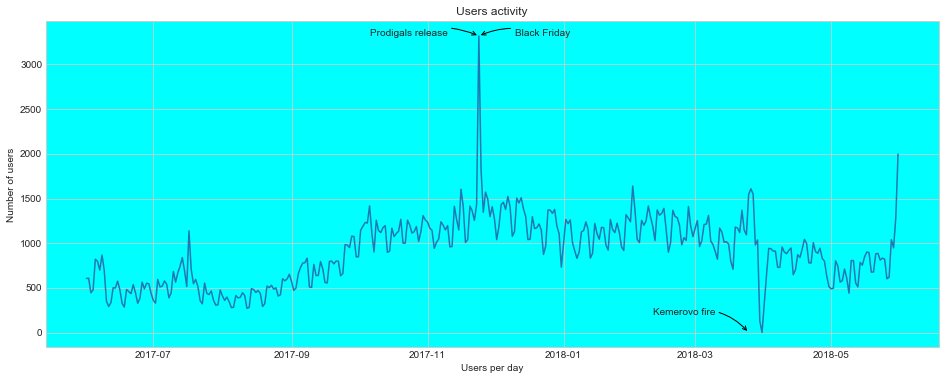

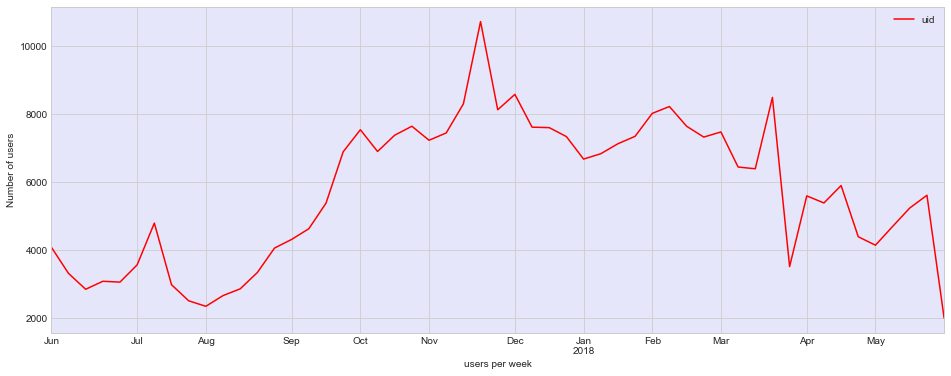

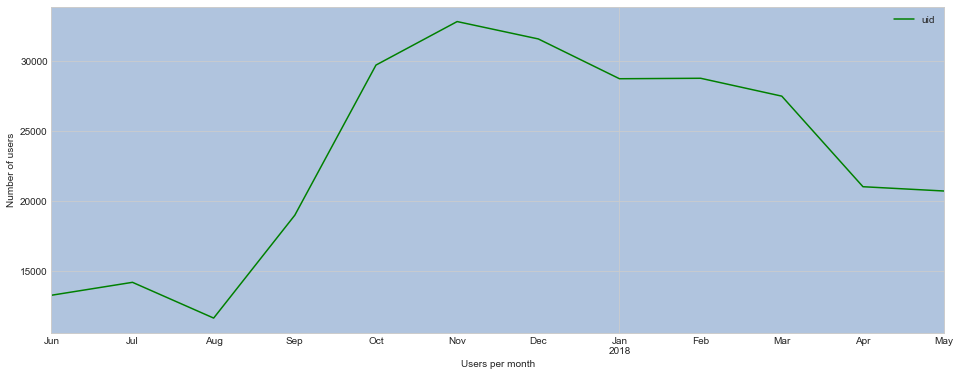

In [13]:
search=dau
search.index=pd.to_datetime(dau.index)
print(colored('Pick of activity during christmas:',on_color='on_yellow'),'\n',search['2017-11-22':'2017-11-26'])

#plot the DAU(daily active users,),WAU,MAU
fig,axes=plt.subplots(figsize=(16,6))

axes.plot(dau.index,dau.uid)
axes.set_facecolor(color='aqua')
axes.annotate('Kemerovo fire',xy=('2018-03-25',1),xytext=('2018-03-10',200),\
              ha='right',arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=-0.3"))
axes.annotate('Prodigals release',xy=('2017-11-24',3319),xytext=('2017-11-10',3319),\
             ha='right',arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=-0.2"))
axes.annotate('Black Friday',xy=('2017-11-24',3319),xytext=('2017-12-10',3319),\
             ha='left',arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=0.2"))
axes.set_ylabel('Number of users')
axes.set_xlabel('Users per day')
axes.set_title('Users activity')


#drastic drop of actvity
drop=dau
drop.index=pd.to_datetime(drop.index)
print(colored('Drastic drop of active users:',on_color='on_red'),'\n',drop['2018-03-29':'2018-04-02'])
print(colored(\
'Kemerovo fire on 25 March ,probably influenced people and keep them away from social activites for a while.',\
             color='red',on_color='on_cyan'))

wau.plot(figsize=(16,6),color='red',grid=True).set_facecolor(color='lavender')
plt.xlabel('users per week')
plt.ylabel('Number of users')

mau.plot(figsize=(16,6),color='green',grid=True).set_facecolor(color='lightsteelblue')
plt.xlabel('Users per month')
plt.ylabel('Number of users')
plt.show()

* It is noticable the abnormal activity on 2017-11-24, where could be explained by the fact that was Black Friday and also we can assume the realise of the movie "Prodigals" could have prompted users to book tickets since that was the most viewed movie released on 2017.On 25 March 2018 along side to a potential server break down, another event had taken place that could have possible influenced people to stay away from social activities, the fire on a shopping mall. https://en.wikipedia.org/wiki/2018_Kemerovo_fire.
* Besides the pick of activity during Christmas period and the drastic drop on 2018-03-31, we observe common behaviour for the winter months in both plots for week and montly active users.It makes sense a higher activity during September to February since people lead to indoor activities like cinema, theater and so.

    device  user_device
0  desktop       164523
1    touch        71345 
 Total devices: 235868


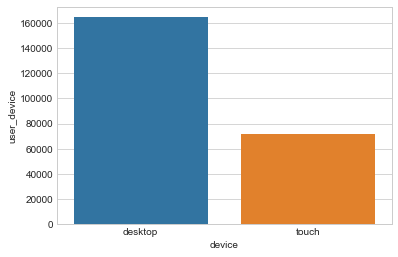

In [15]:
# What is the distribution of the devices
dev=visits.groupby('device')['uid'].nunique().reset_index().rename(columns={'uid':'user_device'})
print(dev,'\n',colored('Total devices:',on_color='on_green'),dev['user_device'].sum())

sns.barplot(x='device',y='user_device',data=dev)
sns.set_theme(style="darkgrid")
plt.show()

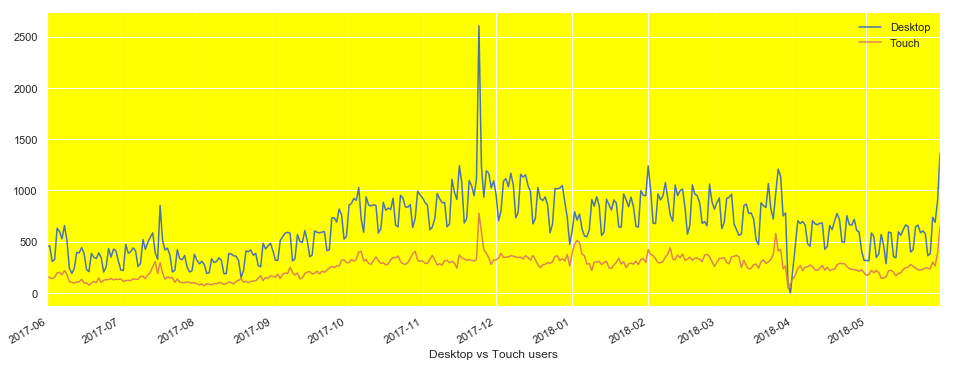

In [16]:
# activity of each device
fig,axes=plt.subplots()
ax1=visits[visits['device']=='desktop'].groupby('start_ts_date').agg({'uid':'nunique'})\
.reset_index().plot(x='start_ts_date',y='uid',ax=axes,figsize=(16,6),grid=True,label='Desktop')
ax2=visits[visits['device']=='touch'].groupby('start_ts_date').agg({'uid':'nunique'})\
.reset_index().plot(x='start_ts_date',y='uid',ax=axes,figsize=(16,6),grid=True,label='Touch')
ax1.set_facecolor("yellow")
plt.xlabel('Desktop vs Touch users')
plt.show()

* The majority of the users use desktop with a population of 164523 over 71345 which use a touch device out of a total 235868 devices.

In [17]:
# mean dau,wau,mau
dau_mean=visits.groupby('start_ts_date')['uid'].nunique().mean()
wau_mean=visits.groupby('start_ts_week')['uid'].nunique().mean()
mau_mean=visits.groupby('start_ts_month')['uid'].nunique().mean()
print('Mean DAU: {:.2f}'.format(dau_mean))
print('Mean WAU: {:.2f}'.format(wau_mean))
print('Mean MAU: {:.2f}'.format(mau_mean))

Mean DAU: 907.99
Mean WAU: 5724.42
Mean MAU: 23228.42


In [18]:
#calculate the sticky factor for week and month
sticky_week=dau_mean/wau_mean
sticky_month=dau_mean/mau_mean
print('Sticky week factor:{:.2%}'.format(sticky_week))
print('Sticky month factor:{:.2%}'.format(sticky_month))

Sticky week factor:15.86%
Sticky month factor:3.91%


In [19]:
dau_mean_2017=visits[visits['start_ts_year']=='2017'].groupby('start_ts_date')['uid'].nunique().mean()
dau_mean_2018=visits[visits['start_ts_year']=='2018'].groupby('start_ts_date')['uid'].nunique().mean()
wau_mean_2017=visits[visits['start_ts_year']=='2017'].groupby('start_ts_week')\
['uid'].nunique().mean()
wau_mean_2018=visits[visits['start_ts_year']=='2018'].groupby('start_ts_week')\
['uid'].nunique().mean()
mau_mean=visits.groupby('start_ts_month')['uid'].nunique().mean()
mau_mean_2017=visits[visits['start_ts_year']=='2017'].groupby('start_ts_month')['uid'].nunique().mean()
mau_mean_2018=visits[visits['start_ts_year']=='2018'].groupby('start_ts_month')['uid'].nunique().mean()
sticky_week=dau_mean/wau_mean
sticky_month=dau_mean/mau_mean
sticky_week_2017=dau_mean_2017/wau_mean_2017
sticky_week_2018=dau_mean_2018/wau_mean_2018
sticky_month_2017=dau_mean_2017/mau_mean_2017
sticky_month_2018=dau_mean_2018/mau_mean_2018

print('Sticky week factor:{:.2%}'.format(sticky_week))
print('Sticky month factor:{:.2%}'.format(sticky_month))
print('Sticky week factor for 2017:{:.2%}'.format(sticky_week_2017))
print('Sticky week factor for 2018:{:.2%}'.format(sticky_week_2018))
print('Sticky monthly factor for 2017:{:.2%}'.format(sticky_month_2017))
print('Sticky monthly factor for 2018:{:.2%}'.format(sticky_month_2018))


Sticky week factor:15.86%
Sticky month factor:3.91%
Sticky week factor for 2017:15.80%
Sticky week factor for 2018:16.66%
Sticky monthly factor for 2017:3.89%
Sticky monthly factor for 2018:3.94%


* We see that the monthly loyalty as well the weekly engagement of the users is slightly better for the 2018 year than 2017. 

In [20]:
visits.head()

,device,end_ts,source_id,start_ts,uid,start_ts_date,start_ts_week,start_ts_month,start_ts_year
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,2017-01-01
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,2018-01-01
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,2017-01-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,2018-01-01
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,2017-01-01


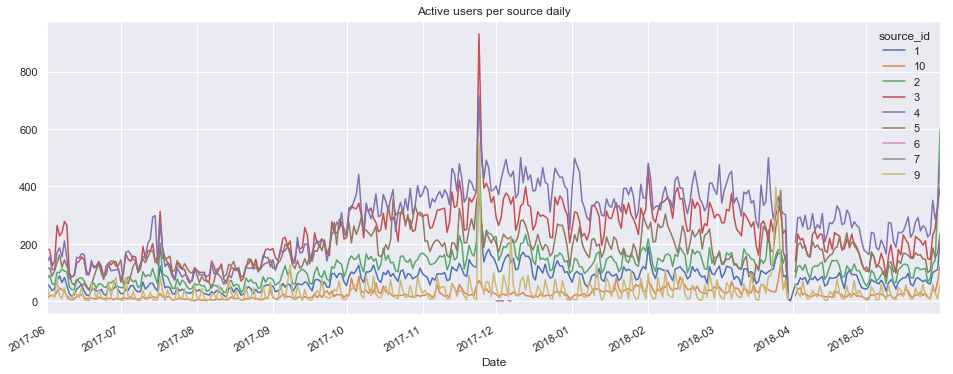

,start_ts_date,source_id,uid
1238,2017-11-22,3,361
1245,2017-11-23,3,385
1252,2017-11-24,3,932
1259,2017-11-25,3,543
1266,2017-11-26,3,394


Devices distribution of source 3: 
 desktop    794
touch      171
Name: device, dtype: int64


In [21]:
#active users per source per day
sources=visits.groupby(['start_ts_date','source_id'])['uid'].nunique().reset_index()

sources.pivot_table(index='start_ts_date',values='uid',columns='source_id').plot(figsize=(16,6),grid=True)
plt.xlabel('Date')
plt.title('Active users per source daily')
plt.show()

#look closer the values of the pick for the source 3
test=sources
test['start_ts_date']=pd.to_datetime(test['start_ts_date'])
search=test[test['source_id']=='3']
display(search[(search['start_ts_date']>='2017-11-22') & (search['start_ts_date']<='2017-11-26')])


#find the distribution of the devices on the pick day of the source 3
print('Devices distribution of source 3:','\n',\
      visits[(visits['start_ts'].astype('datetime64[D]')=='2017-11-24') & (visits['source_id']=='3')]\
      ['device'].value_counts())

* Sources 4 and 3 have are the main sources the users come from. We see that source 3 had a higher pick on 2017-11-24, with 932 active users where 794 of them came from a desktop device while 171 from a touch device.
* On 2017-11-25 was the realise of the most viewed movie for the 2017 'Prodigals', probably many users wanted to book tickets in order to see it immediately.

* **How many sessions are there per day? (One user might have more than one session.)**

In [22]:
#sessions per day, average sessions per day
sessions_day=visits.groupby('start_ts_date').agg({'uid':['count','nunique']})
sessions_day.columns=['n_sessions','n_users']

#sessions per day, per device
sessions_day_desktop=visits[visits['device']=='desktop'].groupby('start_ts_date').agg({'uid':['count','nunique']})
sessions_day_desktop.columns=['n_sessions_desktop','n_users_desktop']
sessions_day_touch=visits[visits['device']=='touch'].groupby('start_ts_date').agg({'uid':['count','nunique']})
sessions_day_touch.columns=['n_sessions_touch','n_users_touch']

#average sessions per user
avg_sessions_day_per_user=(sessions_day['n_sessions']/sessions_day['n_users']).mean()
print(avg_sessions_day_per_user)

#average sessions per desktop user
avg_sessions_day_per_desktop_user=(sessions_day_desktop['n_sessions_desktop']/sessions_day_desktop\
                                   ['n_users_desktop']).mean()
print(avg_sessions_day_per_desktop_user)

#average sessions per touch user
avg_sessions_day_per_touch_user=(sessions_day_touch['n_sessions_touch']/sessions_day_touch\
                                   ['n_users_touch']).mean()
print(avg_sessions_day_per_touch_user)

1.0821696440039723
1.088955311524761
1.051071574166503


Average number of sessions per user daily: 1.08


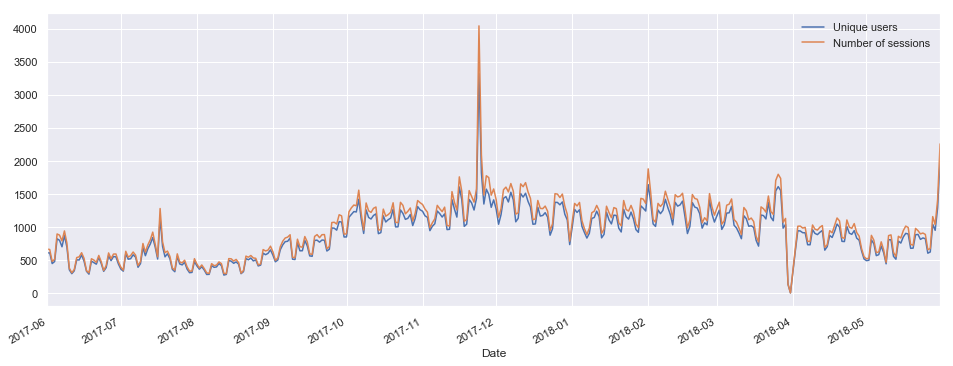

In [23]:
#Average number of sessions per user daily
print(colored('Average number of sessions per user daily:',on_color='on_yellow'),round(avg_sessions_day_per_user,2))

#plot unique users vs number of dialy sessions
fig,axes=plt.subplots()
ax1=sessions_day.reset_index()\
.plot(y='n_users',x='start_ts_date',figsize=(16,6),grid=True,ax=axes,label='Unique users')
ax2=sessions_day.reset_index()\
.plot(y='n_sessions',x='start_ts_date',figsize=(16,6),grid=True,ax=axes,label='Number of sessions')
plt.xlabel('Date')
plt.show()

* We see above that some users have more than one session a day and that takes place mostly during winte time 2017-10 till 2018-03

Average number of sessions per Desktop_user daily: 1.09
Average number of sessions per Touch_user daily: 1.05


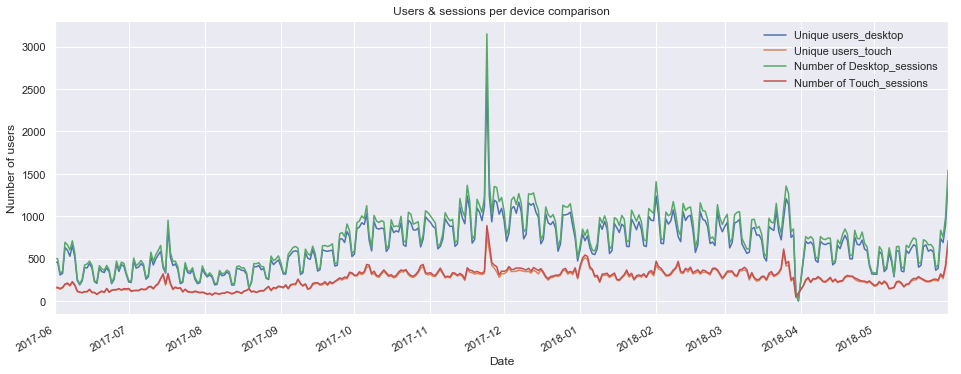

In [24]:
#Average number of sessions per desktop_user daily
print(colored('Average number of sessions per Desktop_user daily:',on_color='on_yellow')\
      ,round(avg_sessions_day_per_desktop_user,2))

#Average number of sessions per touch_user daily
print(colored('Average number of sessions per Touch_user daily:',on_color='on_green')\
      ,round(avg_sessions_day_per_touch_user,2))



fig,axes=plt.subplots()
#distribution of unique users

ax2=sessions_day_desktop.reset_index()\
.plot(y='n_users_desktop',x='start_ts_date',figsize=(16,6),grid=True,ax=axes,label='Unique users_desktop')
ax3=sessions_day_touch.reset_index()\
.plot(y='n_users_touch',x='start_ts_date',figsize=(16,6),grid=True,ax=axes,label='Unique users_touch')

#distribution of sessions

ax5=sessions_day_desktop.reset_index()\
.plot(y='n_sessions_desktop',x='start_ts_date',figsize=(16,6),grid=True,ax=axes,label='Number of Desktop_sessions')
ax6=sessions_day_touch.reset_index()\
.plot(y='n_sessions_touch',x='start_ts_date',figsize=(16,6),grid=True,ax=axes,label='Number of Touch_sessions')

plt.title('Users & sessions per device comparison')
plt.ylabel('Number of users')
plt.xlabel('Date')
plt.show()

* We see that during winter months mainly the desktop users having more sessions daily than the touch users.Makes sense since people spending more time home so is more convenient to use the desktop than a touch device.

* **What is the length of each session?**

In [25]:
#Length of each session in seconds
visits['duration']=(visits['end_ts']-visits['start_ts']).dt.seconds

Number of sessions with zero duration: 35794


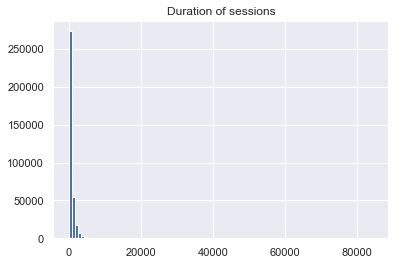

In [26]:
#Investigating the duration of the sessions
print('Number of sessions with zero duration:',(visits['duration']==0).sum())
visits['duration'].hist(bins=100)
plt.title('Duration of sessions')
plt.show()

* Since the distribution above is not close to normal and we have many zero duration values it would be more objective to take into account as mean session time the mode of the duration( most frequent duration)
* timestamps are rounded to the minute so it would be not reliable to move out the logs with zero duration cause could be not zero but less than 60 seconds

In [27]:
# Average session length
asl=visits['duration'].mode()[0]
asl


60

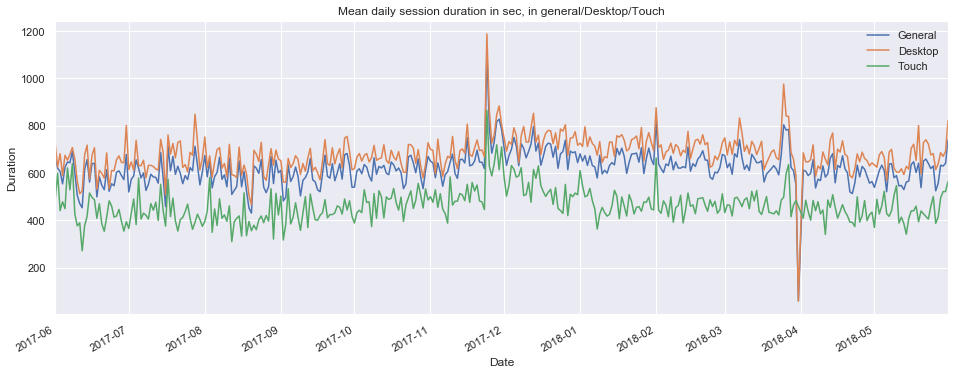

In [28]:
fig,axes=plt.subplots()
visits.groupby('start_ts_date')['duration'].mean().plot(ax=axes,figsize=(16,6),label='General',grid=True)
visits[visits['device']=='desktop'].groupby('start_ts_date')['duration']\
.mean().plot(ax=axes,figsize=(16,6),label='Desktop')
visits[visits['device']=='touch']\
.groupby('start_ts_date')['duration'].mean().plot(ax=axes,figsize=(16,6),label='Touch',grid=True)
plt.ylabel('Duration')
plt.xlabel('Date')
plt.legend()
plt.title('Mean daily session duration in sec, in general/Desktop/Touch')
plt.show()

* The mean time of session for the desktop users is almsot always greater than the touch devices users besides the 2018-03-31 where people were inactive cause of the fire in the mall.Nevertheless, touch users were active on the date.Maybe these users were not informed by media or tv, or they were not home to spend their time on tv.

* How often do users come back?
> We have to find the retention rate.We will try per month

In [29]:
display(visits.head(1))
visits2=visits[['device','end_ts','source_id','start_ts','uid']]
display(visits2.head(1))

,device,end_ts,source_id,start_ts,uid,start_ts_date,start_ts_week,start_ts_month,start_ts_year,duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,2017-01-01,1080


,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062


In [30]:
#we have to find the retention rate 
first_activity_date=visits.groupby('uid')['start_ts'].min().astype('datetime64[M]')

#name the values of the series first_activity_date
#the first_activity_month will be the name of each cohort
#characteristics of a cohort (event:first activity, certain time:same month)
first_activity_date.name='first_activity_month'

#join to the visits table the first_activity_date
visits2=visits2.merge(first_activity_date,on='uid')

#find the lifetime(age) of each cohort
visits2['cohort_activity_lifetime']=round((visits2['start_ts'].astype('datetime64[M]')\
                                   -visits2['first_activity_month'])/np.timedelta64(1,'M'))

visits2['cohort_activity_lifetime']=visits2['cohort_activity_lifetime'].astype('int')

In [32]:
visits2.head()

,device,end_ts,source_id,start_ts,uid,first_activity_month,cohort_activity_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-01,0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-03-01,2
4,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018-03-01,0


In [33]:
#find the number of active users of each cohort for the nth month of cohort's life
cohorts_users=visits2.groupby(['first_activity_month','cohort_activity_lifetime'])\
.agg({'uid':'nunique'}).reset_index().rename(columns={'uid':'users'})


#find the retention rate of each cohort for each month of life
#find the initial users of each cohort
initial_users=cohorts_users[cohorts_users['cohort_activity_lifetime']==0][['first_activity_month','users']]\
.rename(columns={'users':'cohort_users'})

#join the result to the cohorts_users table
cohorts_users=cohorts_users.merge(initial_users,on='first_activity_month')
display(cohorts_users.head(3))

#calculate the retention rate of active users
cohorts_users['retention']=cohorts_users['users']/cohorts_users['cohort_users']
cohorts_users.head(3)

,first_activity_month,cohort_activity_lifetime,users,cohort_users
0,2017-06-01,0,13259,13259
1,2017-06-01,1,1043,13259
2,2017-06-01,2,713,13259


,first_activity_month,cohort_activity_lifetime,users,cohort_users,retention
0,2017-06-01,0,13259,13259,1.000000
1,2017-06-01,1,1043,13259,0.078664
2,2017-06-01,2,713,13259,0.053775


In [34]:
#we will compile a pivot table to visualize the retention of activity for each cohort
ret_pivot=cohorts_users.pivot_table\
(index='first_activity_month',values='retention',columns='cohort_activity_lifetime',aggfunc='sum')
display(ret_pivot)

cohort_activity_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,1.0,0.078664,0.053775,0.061392,0.068557,0.071423,0.061015,0.057772,0.052342,0.050833,0.040652,0.044951
2017-07-01,1.0,0.056088,0.051294,0.056164,0.058219,0.048174,0.045358,0.045738,0.038813,0.028615,0.027473,NaN
2017-08-01,1.0,0.076908,0.062862,0.062764,0.050093,0.044004,0.036342,0.039485,0.027895,0.026029,NaN,NaN
2017-09-01,1.0,0.085489,0.069205,0.050706,0.039392,0.037835,0.035860,0.024186,0.022809,NaN,NaN,NaN
2017-10-01,1.0,0.078608,0.052239,0.038958,0.034261,0.032221,0.021365,0.020364,NaN,NaN,NaN,NaN
2017-11-01,1.0,0.078281,0.044113,0.038682,0.033727,0.023415,0.021800,NaN,NaN,NaN,NaN,NaN
2017-12-01,1.0,0.055802,0.037993,0.031107,0.020263,0.019036,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,1.0,0.059715,0.039339,0.024973,0.020244,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,1.0,0.057080,0.025454,0.020093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


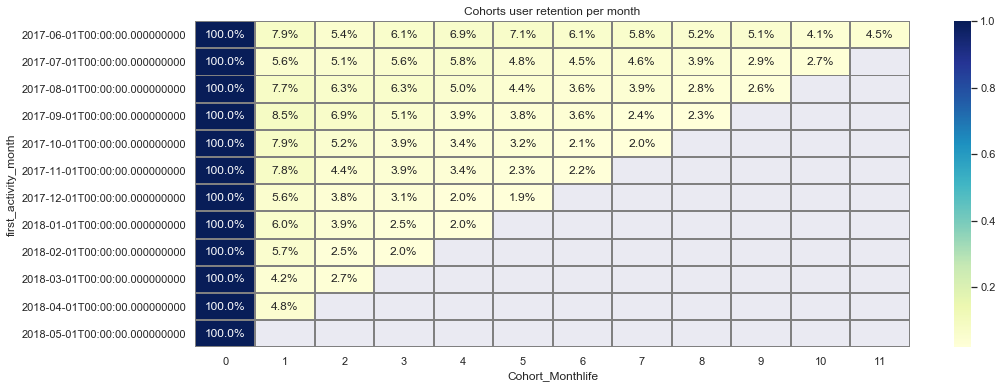

In [35]:
plt.figure(figsize=(16,6))
sns.heatmap(data=ret_pivot,fmt='.1%',annot=True,linewidths=1,linecolor='gray',cmap = "YlGnBu"\
           ,vmax=1)
plt.xlabel('Cohort_Monthlife')
plt.title('Cohorts user retention per month')
plt.show()

* We see that some users of  the 2017-06-01 cohort return after the 2nd month and reach a pick of their retention on 5th month before the retention rate drop again.
* The same we can observe for the 2017-07-01 on 4th month of their life while users of 2017-08-01 where satble for the 2nd and 3rd month before they start to leave again.
* For the rest of the cohorts users they withdraw constanly every month after their first month of activity.

> 2.Sales
- Here we are interested when people start buying, how much time elapses from their registration to their first purchase.Therefore, we will measure the conversion rate.

In [36]:
display(visits2.head(1))
sales=visits2.drop(['first_activity_month','cohort_activity_lifetime'],axis=1)
display(sales.head(1))

,device,end_ts,source_id,start_ts,uid,first_activity_month,cohort_activity_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-01,0


,device,end_ts,source_id,start_ts,uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062


In [37]:
#check out if people buy same day of registration. first visit = first buy
first_activity= sales.groupby('uid')['start_ts'].min().reset_index().rename(columns={'start_ts':'first_act'})
orders=orders.merge(first_activity,on='uid',how='left')

In [38]:
orders.head(2)

,buy_ts,revenue,uid,first_act
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00


* We see that there are users that made a purchase the day of registration 

In [39]:
#check if there is any wrong log
display(orders[orders['first_act']>orders['buy_ts']].head())

#check how many users buy the day of their registration
print('{} users made a purchase on their registration day'.\
      format(orders[orders['first_act']==orders['buy_ts']].shape[0]))
print('Total users:{}'.format(visits['uid'].nunique()))

,buy_ts,revenue,uid,first_act


2455 users made a purchase on their registration day
Total users:228169


* When people start buying. Time that elapses between the registration or first visit till become customers.

We want conversion rate for each cohort for each conversion day.So for each cohort, 
how many unique users exist in each cohort initially and how many convert to buyers in each day

In [40]:
#we merge the visits2 to orders(left), cause we are interested in the buyers now
conv=orders[['buy_ts','uid']].merge(visits2[['uid','start_ts','source_id']],on='uid',how='left')

#we will create a table of users only with their first purchase data and their cohorts
first_purchase=conv.groupby('uid')['buy_ts'].min().reset_index().rename(columns={'buy_ts':'first_buy'})

#first activity
first_activity= conv.groupby('uid')['start_ts'].min().reset_index().rename(columns={'start_ts':'first_act'})
first_purchase=first_purchase.merge(first_activity,on=['uid'])
display(first_purchase.head(2))

#cohort name
first_purchase['cohort']=first_purchase['first_act'].apply(lambda x: x.strftime('%Y-%m'))
display(first_purchase.head(2))

#initial users of each cohorts
initial_users=first_purchase.groupby('cohort')['uid'].nunique().reset_index().rename(columns={'uid':'cohort_users'})
first_purchase=first_purchase.merge(initial_users,on='cohort')
display(first_purchase.head(2))

#find the time elapsed for each user's conversion in days
first_purchase['days_of_conversion']=((first_purchase['first_buy']-first_purchase['first_act'])\
                                      /np.timedelta64(1,'D')).round().astype('int')
display(first_purchase.head(2))

#find the number of the buyers of each cohort in each conversion day
current_day_cohort_buyers=first_purchase.groupby(['cohort','days_of_conversion'])\
['uid'].nunique().reset_index().rename(columns=({'uid':'cohort_day_buyers'}))
first_purchase=first_purchase.merge(current_day_cohort_buyers,on=['cohort','days_of_conversion'],how='left')
display(first_purchase.head(2))

#conversion rate for each cohort in certain conversion days
first_purchase['conversion_rate']=first_purchase['cohort_day_buyers']/first_purchase['cohort_users']
display(first_purchase.head(2))

,uid,first_buy,first_act
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00


,uid,first_buy,first_act,cohort
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,2017-09
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,2017-06


,uid,first_buy,first_act,cohort,cohort_users
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,2017-09,3058
1,12695041396440380,2017-09-01 23:54:00,2017-09-01 21:45:00,2017-09,3058


,uid,first_buy,first_act,cohort,cohort_users,days_of_conversion
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,2017-09,3058,107
1,12695041396440380,2017-09-01 23:54:00,2017-09-01 21:45:00,2017-09,3058,0


,uid,first_buy,first_act,cohort,cohort_users,days_of_conversion,cohort_day_buyers
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,2017-09,3058,107,2
1,12695041396440380,2017-09-01 23:54:00,2017-09-01 21:45:00,2017-09,3058,0,1888


,uid,first_buy,first_act,cohort,cohort_users,days_of_conversion,cohort_day_buyers,conversion_rate
0,313578113262317,2018-01-03 21:51:00,2017-09-18 22:49:00,2017-09,3058,107,2,0.000654
1,12695041396440380,2017-09-01 23:54:00,2017-09-01 21:45:00,2017-09,3058,0,1888,0.617397


In [41]:
conv_pivot=first_purchase.pivot_table(index='cohort',values='conversion_rate',columns='days_of_conversion')
pd.set_option('display.max_columns',500)
display(conv_pivot)

days_of_conversion,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,300,301,303,304,305,306,307,308,309,312,313,314,316,317,318,319,320,321,322,323,324,325,326,328,329,331,332,334,335,336,338,339,341,342,343,344,345,346,347,348,349,350,352,353,355,356,357,358,363
cohort,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2017-06,0.590147,0.037633,0.013000,0.010606,0.009579,0.004790,0.007184,0.003763,0.004447,0.002395,0.002053,0.002053,0.001026,0.003079,0.002737,0.001368,0.000684,0.001711,0.002053,0.002737,0.003079,0.004105,0.002395,0.000684,0.002395,0.001368,0.001368,0.004105,0.001368,0.002395,0.001368,0.001026,0.000342,0.001711,0.001026,0.001368,0.002053,0.002053,0.001368,0.002053,0.000342,NaN,0.001711,0.002395,0.000684,0.000342,0.000684,0.000342,0.000684,0.001026,0.000684,0.001711,0.002053,0.000342,0.000684,0.000342,0.000684,0.001026,0.001026,0.000342,0.001711,0.000684,0.001711,NaN,0.001026,NaN,0.001026,NaN,0.001026,0.001711,0.001368,0.000684,0.001026,0.000684,0.001711,0.000342,0.001026,0.000684,0.002053,0.001026,0.000342,0.000684,0.000684,0.002053,0.000342,0.001711,0.001026,0.002053,0.000342,0.000342,0.001711,0.001026,0.002737,0.001026,0.000684,0.001026,0.001368,0.000684,0.001026,0.002053,0.000342,0.002053,0.000684,0.001026,0.000342,0.001368,0.000684,0.001368,0.001711,0.001368,NaN,0.000684,0.002053,0.001026,0.002053,0.000342,0.002737,0.001711,0.001368,0.002395,0.002053,0.002395,0.001026,0.001711,0.003421,0.001026,0.000684,0.001711,0.000684,0.000342,0.001711,0.001026,0.000684,0.001026,0.001026,0.000342,0.001711,0.001368,0.000342,0.000684,NaN,0.001026,0.001368,0.001368,0.000684,0.001026,0.001026,0.001026,0.001026,0.001711,0.001026,0.001368,0.000684,0.001711,0.000342,0.000342,0.001026,0.001368,0.001368,0.000684,0.001711,0.001026,0.001711,0.000342,0.001026,NaN,0.000342,0.000684,0.000684,0.001368,NaN,0.001368,0.001026,0.001026,0.002053,0.000342,0.001026,0.001026,0.002053,0.000684,0.001368,0.000342,0.000684,0.001368,0.000342,0.001026,0.000684,0.001026,0.001368,0.001026,0.001711,NaN,0.000684,0.002053,0.000342,0.000684,0.001026,0.000342,NaN,0.000342,0.000684,0.000684,0.001368,0.000684,0.000342,0.000342,0.001026,0.000342,0.000342,0.000684,0.001026,0.000684,0.000684,0.001026,0.000684,0.000342,0.000342,0.000684,0.000684,0.000684,0.000342,NaN,0.001368,0.001711,0.000684,0.001368,0.000342,0.000684,0.001026,0.000684,0.001711,0.000342,0.001026,0.001026,0.000684,NaN,0.000684,0.000342,0.001026,0.001026,0.000684,0.000342,NaN,0.000342,0.000684,0.000342,NaN,0.000342,0.000684,0.001026,0.000684,NaN,0.002053,0.002053,NaN,0.001368,0.001026,0.000684,0.001368,NaN,0.000342,0.000684,NaN,0.000684,0.002053,0.001368,0.001368,0.001026,0.000342,0.000

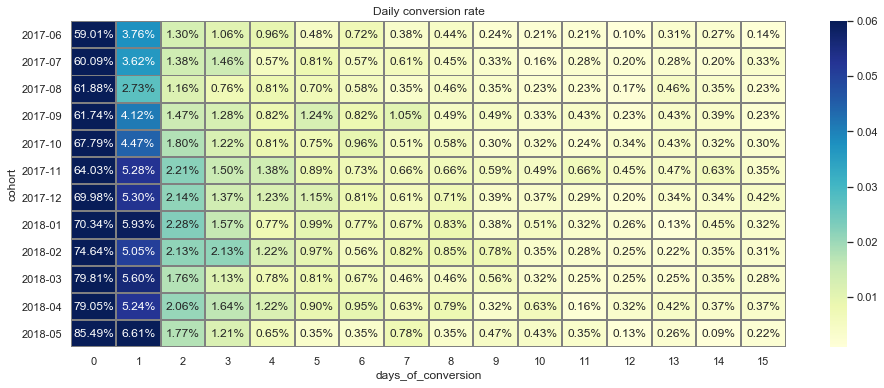

In [44]:
#plot the first 16 days since after reaches closer the zero the conversion rate
plt.figure(figsize=(16,6))
sns.heatmap(conv_pivot.iloc[:,:16],fmt='.2%',cmap="YlGnBu",\
            annot=True,linecolor='gray',linewidth=1,vmax=0.06)
plt.title('Daily conversion rate')
plt.show()

* Generally after the first day of conversion every cohort drops drastically its rate but the more we move to the 2018 the first day of conversion has a constant higher rate while the next 2 days keep to perform better than the early 2017 cohorts.
* The 2018-05 cohort perfomed better from all at the first conversion day.

In [45]:
conv.head()

,buy_ts,uid,start_ts,source_id
0,2017-06-01 00:10:00,10329302124590727494,2017-06-01 00:09:00,1
1,2017-06-01 00:25:00,11627257723692907447,2017-06-01 00:14:00,2
2,2017-06-01 00:27:00,17903680561304213844,2017-06-01 00:25:00,2
3,2017-06-01 00:29:00,16109239769442553005,2017-06-01 00:14:00,2
4,2017-06-01 07:58:00,14200605875248379450,2017-06-01 07:31:00,3


In [46]:
#traffic source conversion rate
#traffic source of first visit & first buy
#in order to achive that we have to find the traffic source of the first visit
#sort the visit timestamp first to bring to the top the row with the first visit source_id
conv_traffic=conv.sort_values('start_ts')
display(conv_traffic.head())

#find first visit                               
first_visit=conv_traffic.groupby('uid')['start_ts'].min().reset_index().rename(columns={'start_ts':'1st_visit'})
conv_traffic=conv_traffic.merge(first_visit,on='uid',how='left')
display(conv_traffic.head(1))

,buy_ts,uid,start_ts,source_id
0,2017-06-01 00:10:00,10329302124590727494,2017-06-01 00:09:00,1
1,2017-06-01 00:25:00,11627257723692907447,2017-06-01 00:14:00,2
3,2017-06-01 00:29:00,16109239769442553005,2017-06-01 00:14:00,2
2,2017-06-01 00:27:00,17903680561304213844,2017-06-01 00:25:00,2
52903,2017-07-21 14:56:00,16945437833757229838,2017-06-01 01:18:00,2


,buy_ts,uid,start_ts,source_id,1st_visit
0,2017-06-01 00:10:00,10329302124590727494,2017-06-01 00:09:00,1,2017-06-01 00:09:00


In [47]:
#first visit's source
first_source=conv_traffic.groupby('uid',as_index=False).agg({'source_id':'first'})\
.rename(columns={'source_id':'first_traffic'})

conv_traffic=conv_traffic.merge(first_source,on='uid')
display(conv_traffic.head(1))

,buy_ts,uid,start_ts,source_id,1st_visit,first_traffic
0,2017-06-01 00:10:00,10329302124590727494,2017-06-01 00:09:00,1,2017-06-01 00:09:00,1


In [48]:
#first buy
first_buy=conv_traffic.groupby('uid')['buy_ts'].min().reset_index().rename(columns={'buy_ts':'1st_buy'})
conv_traffic=conv_traffic.merge(first_buy,on='uid',how='left')
display(conv_traffic.head(1))

,buy_ts,uid,start_ts,source_id,1st_visit,first_traffic,1st_buy
0,2017-06-01 00:10:00,10329302124590727494,2017-06-01 00:09:00,1,2017-06-01 00:09:00,1,2017-06-01 00:10:00


In [49]:
#source traffic the time of conversion 
buy_source= conv_traffic.sort_values('buy_ts').groupby('uid',as_index=False)\
.agg({'source_id':'first'}).rename(columns={'source_id':'conv_traffic'})
display(buy_source.head(1))

conv_traffic=conv_traffic.merge(buy_source,on='uid')
display(conv_traffic.head())

,uid,conv_traffic
0,313578113262317,2


,buy_ts,uid,start_ts,source_id,1st_visit,first_traffic,1st_buy,conv_traffic
0,2017-06-01 00:10:00,10329302124590727494,2017-06-01 00:09:00,1,2017-06-01 00:09:00,1,2017-06-01 00:10:00,1
1,2017-06-01 00:25:00,11627257723692907447,2017-06-01 00:14:00,2,2017-06-01 00:14:00,2,2017-06-01 00:25:00,2
2,2017-06-01 00:29:00,16109239769442553005,2017-06-01 00:14:00,2,2017-06-01 00:14:00,2,2017-06-01 00:29:00,2
3,2017-06-01 00:27:00,17903680561304213844,2017-06-01 00:25:00,2,2017-06-01 00:25:00,2,2017-06-01 00:27:00,2
4,2017-07-21 14:56:00,16945437833757229838,2017-06-01 01:18:00,2,2017-06-01 01:18:00,2,2017-07-21 14:56:00,3


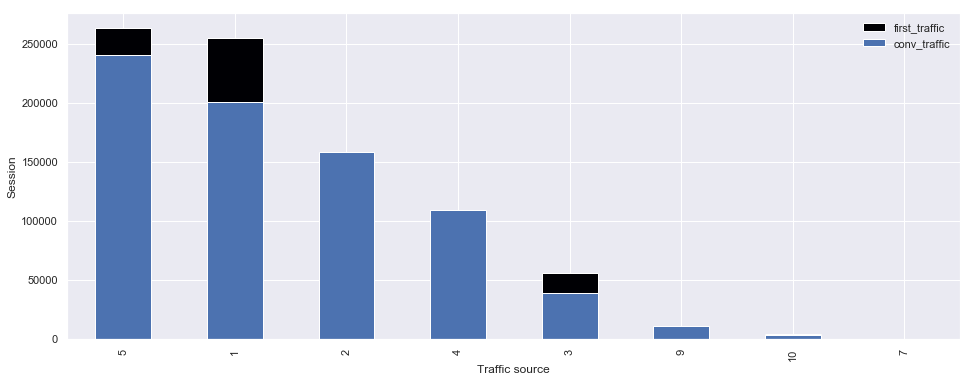

In [50]:
conv_traffic['first_traffic'].value_counts().plot(kind='bar',cmap='inferno',figsize=(16,6)\
                                                  ,legend='Traffic_first_visit',grid=True)
conv_traffic['conv_traffic'].value_counts().plot(kind='bar',legend='Traffic_first_purchase',grid=True)
plt.xlabel('Traffic source')
plt.ylabel('Session')
plt.show()

* The distribution pattern of the traffic sources for the first visit remains the same with that one of the first purchase
* Most popular traffic source seems to be the source number 5
* The traffic source 2 seems the more stable.User do their purchases from the same traffic source
* The source 1 loses the most users from the first visit till they do their first buy.

In [51]:
#find conversion period of days for each user
conv_traffic['conv_days']=((conv_traffic['1st_buy']-conv_traffic['1st_visit'])\
                           /np.timedelta64(1,'D')).round().astype('int')

#name the cohorts
conv_traffic['cohort_traffic']=conv_traffic['1st_visit'].apply(lambda x: x.strftime('%Y-%m'))
display(conv_traffic.head(1))

,buy_ts,uid,start_ts,source_id,1st_visit,first_traffic,1st_buy,conv_traffic,conv_days,cohort_traffic
0,2017-06-01 00:10:00,10329302124590727494,2017-06-01 00:09:00,1,2017-06-01 00:09:00,1,2017-06-01 00:10:00,1,0,2017-06


In [52]:
#changes of the traffic source distribution for each day of conversion
traffic_distribution=round(conv_traffic.groupby('conv_days')['source_id'].value_counts()/conv_traffic\
                           .groupby('conv_days')['1st_buy'].count()*100,2).reset_index()
traffic_distribution.columns=['conv_days', 'source_id','traffic_percentage_day%']
traffic_distribution.head()

,conv_days,source_id,traffic_percentage_day%
0,0,2,29.29
1,0,5,27.60
2,0,1,25.30
3,0,4,8.96
4,0,3,6.81


In [53]:
#Define a function for filtering and ploting the traffic between particular dates.
def traffic_plot_period(start_day,end_day):
    no_days=traffic_distribution[(traffic_distribution['conv_days']>=start_day) & (traffic_distribution['conv_days']\
                                                                                   <=end_day)]
    fig,axe=plt.subplots()
    fig.set_size_inches(16,6)
    sns.barplot(data=no_days,x='conv_days',y='traffic_percentage_day%',hue='source_id',ax=axe)
    plt.xlabel('Days of conversion')
    plt.ylabel('Daily % contribution per source')
    plt.show()

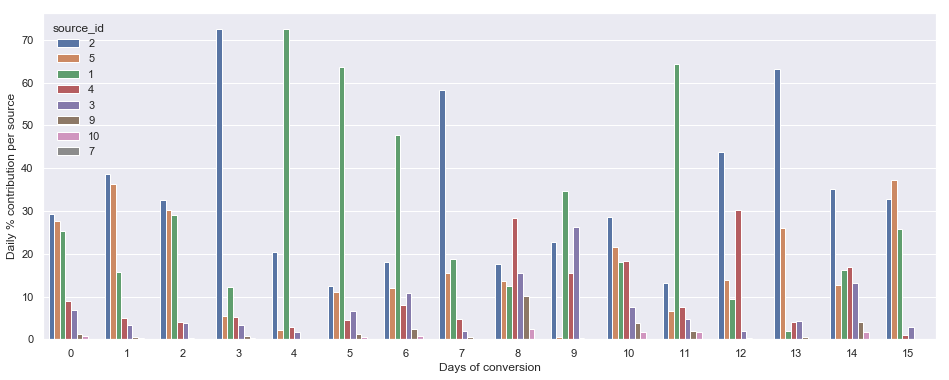

In [54]:
#Check how the distribution of the traffic sources changes during the first 16 days of conversion
traffic_plot_period(0,15)

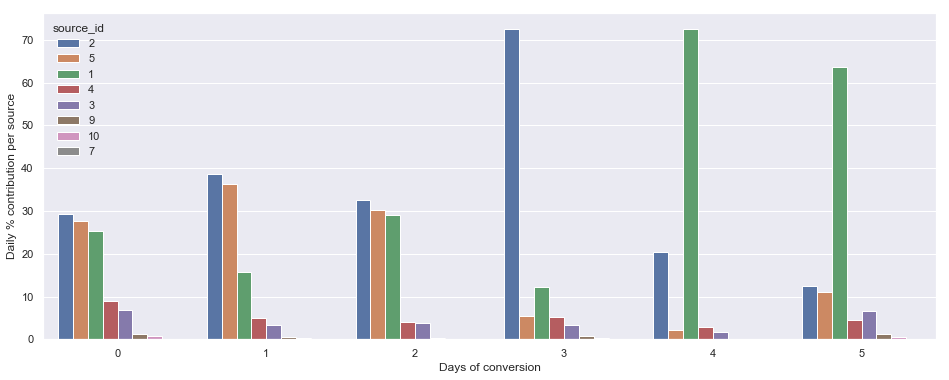

In [57]:
#Check how the distribution of the sources changes during the first 6 days of conversion
traffic_plot_period(0,5)

* Besides that the main traffic sources are the 1,2,5 we don't see any particular pattern to be drawn. We spot alternations between traffic sources 1 and ,2 mainly and for some days source 5

* **How many orders do they make during a given period of time?**
* **What is the average purchase size?**
* **How much money do they bring? (LTV)**

In [58]:
display(orders.head())
#extract the month from each purchase to define cohorts
first_purch=orders.groupby('uid')['buy_ts'].min().reset_index().rename(columns={'buy_ts':'first_buy'})
orders=orders.merge(first_purch,on='uid')
orders['cohort_conv_month']=orders['first_buy'].apply(lambda x: x.strftime('%Y-%m'))

#Find the total revenue per cohort, number of customers per cohort, number of total transactions per cohort
orders_per_cohort=orders.groupby('cohort_conv_month')\
.agg({'buy_ts':'count','revenue':'sum','uid':'nunique'}).reset_index().\
rename(columns={'buy_ts':'total_transactions','revenue':'total_revenue','uid':'number_of_customers'})

#mean revenue per purchase per cohort
orders_per_cohort['mean_purchase']=orders_per_cohort['total_revenue']/orders_per_cohort['total_transactions']


#mean revenue per user per cohort
orders_per_cohort['revenue_user']=orders_per_cohort['total_revenue']/orders_per_cohort['number_of_customers']
orders_per_cohort.head()

,buy_ts,revenue,uid,first_act
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00


,cohort_conv_month,total_transactions,total_revenue,number_of_customers,mean_purchase,revenue_user
0,2017-06,4438,24031.689453,2023,5.414982,11.879234
1,2017-07,2910,16127.919922,1923,5.542241,8.386854
2,2017-08,2188,11606.259766,1370,5.304506,8.471722
3,2017-09,3878,34676.320312,2581,8.941805,13.435227
4,2017-10,6005,27603.449219,4340,4.596744,6.360242


In [59]:
avg_purchase_2017=round(orders[orders['buy_ts'].astype('datetime64[Y]')=='2017']\
                        ['revenue'].sum()/orders[orders['buy_ts']\
                                                 .astype('datetime64[Y]')=='2017']\
                        ['buy_ts'].count(),2)
avg_purchase_2018=round(orders[orders['buy_ts'].astype('datetime64[Y]')=='2018']\
                        ['revenue'].sum()/orders[orders['buy_ts']\
                                                 .astype('datetime64[Y]')=='2018']\
                        ['buy_ts'].count(),2)
_2017_transcations=orders[orders['buy_ts'].astype('datetime64[Y]')=='2017']['buy_ts'].count()
_2018_transcations=orders[orders['buy_ts'].astype('datetime64[Y]')=='2018']['buy_ts'].count()

In [60]:
#average purchase size and total number of orders for the whole time period of data
print('Average purchase size:{}$'.format(round(orders_per_cohort['mean_purchase'].mean(),2)))
print('Total number of orders:{}'.format(orders_per_cohort['total_transactions'].sum()))
print('Average purchase size for the year 2017:{}$'.format(avg_purchase_2017))
print('Average purchase size for the year 2018:{}$'.format(avg_purchase_2018))
print('Total number of 2017 transcations:{}'.format(_2017_transcations))
print('Total number of 2018 transcations:{}'.format(_2018_transcations))

Average purchase size:4.92$
Total number of orders:50415
Average purchase size for the year 2017:5.12$
Average purchase size for the year 2018:4.85$
Total number of 2017 transcations:27467
Total number of 2018 transcations:22948


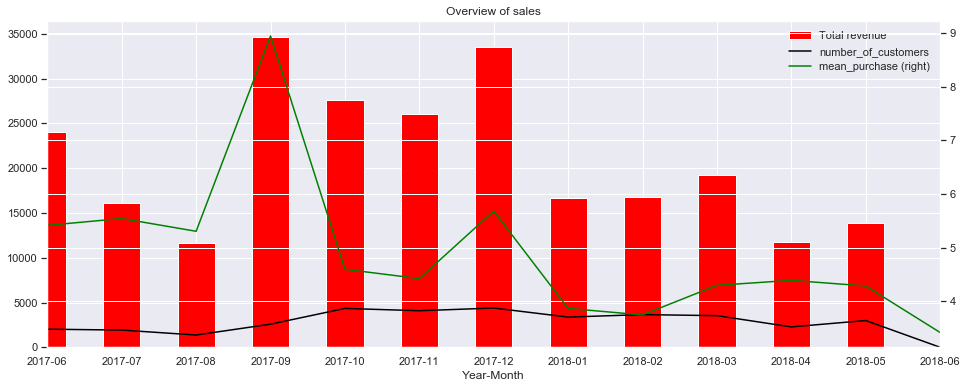

In [61]:
fig,axes= plt.subplots()
orders_per_cohort.plot(kind='bar',x='cohort_conv_month',y='total_revenue',figsize=(16,6),ax=axes,grid=True,\
                      color='red',label='Total revenue')
orders_per_cohort.plot(x='cohort_conv_month',y='number_of_customers',figsize=(16,6),ax=axes,grid=True,\
                      color='black')
orders_per_cohort.plot(x='cohort_conv_month',y='mean_purchase',secondary_y=True,figsize=(16,6)\
                       ,ax=axes,grid=True,color='green')

plt.title('Overview of sales')
axes.set_xlabel("Year-Month")
plt.show()

* We see that the best performed cohort was the 2017-09 in total revenue whitout having the higher number of customers. Generally after the cohort of August of 2017 we see all cohorts to bring into the company more than double revenue till the end of the year while after drops for the cohort of January of 2018. It makes sense as we said, since before and during Christmas period people spend more for indoor activities like cinema theater and so and after this period people are not so eager neither have the same money to spend constantly like during holidays. 

In [62]:
# calculate the monthly LTV(lifetime value) for each conversion cohort
report=orders.merge(orders_per_cohort,on='cohort_conv_month')
report.head()

,buy_ts,revenue,uid,first_act,first_buy,cohort_conv_month,total_transactions,total_revenue,number_of_customers,mean_purchase,revenue_user
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01 00:10:00,2017-06,4438,24031.689453,2023,5.414982,11.879234
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01 00:25:00,2017-06,4438,24031.689453,2023,5.414982,11.879234
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2017-06-01 00:27:00,2017-06,4438,24031.689453,2023,5.414982,11.879234
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2017-06-01 00:29:00,2017-06,4438,24031.689453,2023,5.414982,11.879234
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,2017-06-01 07:58:00,2017-06,4438,24031.689453,2023,5.414982,11.879234


In [63]:
#lifetime in months of each buyers cohort
report['lifetime']=((report['buy_ts']-report['first_buy'])/np.timedelta64(1,'M'))\
.round().astype('int')
display(report.head(2))

#monthly ltv. ltv is the total revenue in a certain time,so should be accumulated for each month of lifetime
monthly_ltv=report.pivot_table(index='cohort_conv_month',values='revenue',columns='lifetime',aggfunc='sum')\
.cumsum(axis=1)
monthly_ltv

,buy_ts,revenue,uid,first_act,first_buy,cohort_conv_month,total_transactions,total_revenue,number_of_customers,mean_purchase,revenue_user,lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01 00:10:00,2017-06,4438,24031.689453,2023,5.414982,11.879234,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01 00:25:00,2017-06,4438,24031.689453,2023,5.414982,11.879234,0


lifetime,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort_conv_month,,,,,,,,,,,,,
2017-06,9620.089844,10403.990234,11175.140625,12912.030273,15125.770508,16573.201172,18385.001953,19498.332031,20958.601562,22235.662109,23402.292969,23845.093750,24031.693359
2017-07,11592.259766,12213.939453,13355.439453,14051.869141,14406.019531,14638.729492,14884.879883,15187.189453,15532.279297,15801.689453,16010.929688,16127.919922,NaN
2017-08,7293.899902,8027.989746,8614.139648,9326.580078,9779.719727,10165.299805,10591.709961,10993.809570,11403.229492,11606.259766,NaN,NaN,NaN
2017-09,14851.000000,17372.128906,19902.949219,29003.699219,30569.648438,32446.789062,33288.980469,34161.378906,34539.980469,34676.320312,NaN,NaN,NaN
2017-10,21949.960938,23959.341797,24936.052734,25566.582031,26293.832031,26715.371094,27056.591797,27531.472656,27603.453125,NaN,NaN,NaN,NaN
2017-11,21365.919922,22668.750000,23754.099609,24783.009766,25406.730469,25661.810547,25989.419922,26098.990234,NaN,NaN,NaN,NaN,NaN
2017-12,20696.130859,21849.140625,25889.589844,30617.849609,31965.640625,33429.429688,33485.738281,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,13999.070312,15056.030273,16115.000000,16470.570312,16645.531250,16663.130859,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,15160.959961,16222.519531,16494.558594,16728.558594,16750.498047,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


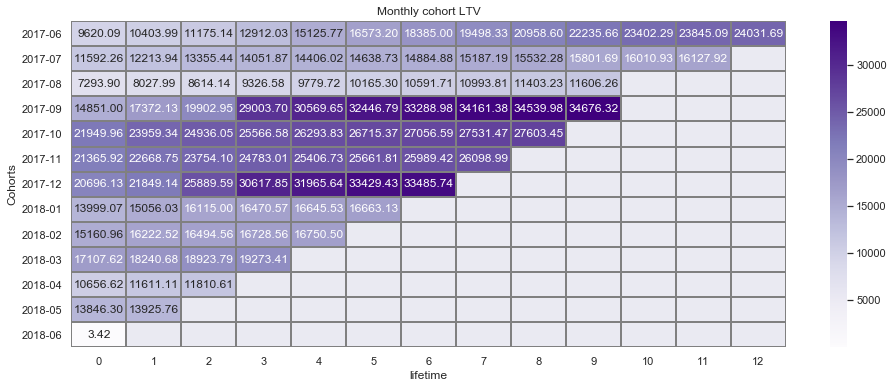

In [65]:
plt.figure(figsize=(16,6))
sns.heatmap(data=monthly_ltv,fmt='.2f',cmap='Purples',linewidths=1,linecolor='gray',annot=True)
plt.ylabel('Cohorts')
plt.title('Monthly cohort LTV')
plt.show()

In [66]:
df_conversion=orders
df_conversion.head()

,buy_ts,revenue,uid,first_act,first_buy,cohort_conv_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01 00:10:00,2017-06
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01 00:25:00,2017-06
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:25:00,2017-06-01 00:27:00,2017-06
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:14:00,2017-06-01 00:29:00,2017-06
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:31:00,2017-06-01 07:58:00,2017-06


In [67]:
#monthly user ltv by cohort- second approach
df_conversion['conv_lifetime']=((df_conversion['buy_ts']-df_conversion['first_buy'])\
/np.timedelta64(1,'M')).astype('int')
display(df_conversion.head(1))

#find total revenue per cohort per month
cohort_revenue=df_conversion.groupby(['cohort_conv_month','conv_lifetime'])['revenue'].sum()\
.reset_index().rename(columns={'revenue':'revenue_cohort_month'})
df_conversion=df_conversion.merge(cohort_revenue,on=['cohort_conv_month','conv_lifetime'])

#cohort users
cohort_no_users=df_conversion.groupby('cohort_conv_month')['uid']\
.nunique().reset_index().rename(columns={'uid':'number_cohort_users'})
df_conversion=df_conversion.merge(cohort_no_users,on='cohort_conv_month')

# monthly revenue per user of each cohort
df_conversion['revenue_user_cohort']=df_conversion['revenue_cohort_month']\
/df_conversion['number_cohort_users']

display(df_conversion.head(2))

#user ltv
ltv_user=df_conversion.pivot_table(index='cohort_conv_month',values='revenue_user_cohort',\
                                  columns='conv_lifetime',aggfunc='mean').cumsum(axis=1)
ltv_user

,buy_ts,revenue,uid,first_act,first_buy,cohort_conv_month,conv_lifetime
0,2017-06-01 00:10:00,17.0,10329302124590727494,2017-06-01 00:09:00,2017-06-01 00:10:00,2017-06,0


,buy_ts,revenue,uid,first_act,first_buy,cohort_conv_month,conv_lifetime,revenue_cohort_month,number_cohort_users,revenue_user_cohort
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01 00:10:00,2017-06,0,9947.040039,2023,4.916975
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01 00:25:00,2017-06,0,9947.040039,2023,4.916975


conv_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
cohort_conv_month,,,,,,,,,,,,
2017-06,4.916975,5.321780,5.795774,6.974415,7.780060,8.731112,9.414163,10.058295,10.601726,11.179545,11.677751,11.879233
2017-07,6.196921,6.510031,7.193832,7.369828,7.544066,7.683557,7.816599,8.007286,8.097015,8.266922,8.386854,NaN
2017-08,5.604912,6.048693,6.528949,6.943649,7.302591,7.557051,7.806416,8.224029,8.397189,8.471722,NaN,NaN
2017-09,6.317257,7.078985,10.751259,11.524389,12.181201,12.723560,13.131658,13.275846,13.435225,NaN,NaN,NaN
2017-10,5.343922,5.637339,5.809245,5.983938,6.104125,6.182408,6.290956,6.360242,NaN,NaN,NaN,NaN
2017-11,5.401642,5.648579,5.920122,6.196949,6.259625,6.330063,6.395244,NaN,NaN,NaN,NaN,NaN
2017-12,4.857876,5.256870,6.459562,7.024360,7.594161,7.639913,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,4.370454,4.626624,4.847569,4.914184,4.940152,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,4.349535,4.471137,4.553750,4.587922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


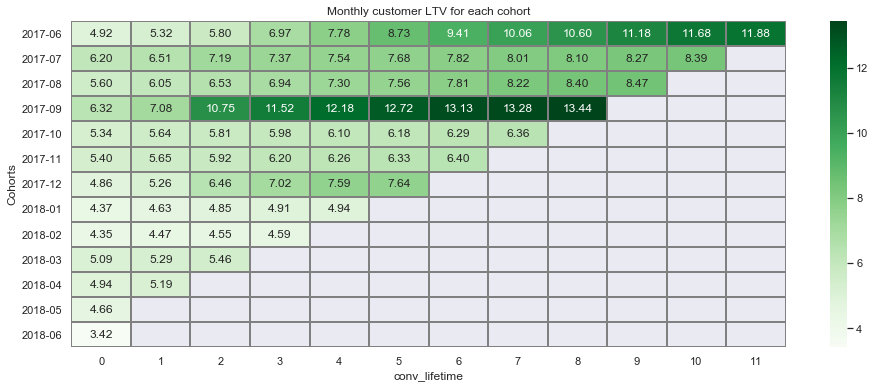

In [69]:
plt.figure(figsize=(16,6))
sns.heatmap(data=ltv_user,fmt='.2f',cmap='Greens',linewidths=1,linecolor='gray',annot=True)
plt.ylabel('Cohorts')
plt.title('Monthly customer LTV for each cohort')
plt.show()

* Cohorts 2017-09 and 2017-12 bring to the company the most, while the 2017-09 cohort perfoms the best for the longest time period than the rest in a 6 months run.
* individually for each customer of each cohort, the cohorts 2017-09 & 2017-06 perfomed better have again the customer lifetime value of 2017-09 cohort the best performance for the whole time period of the lifetime of the cohort, 9 months.

> 3.Marketing
* **How much money was spent? Overall/per source/over time**
* **How much did customer acquisition from each of the sources cost?**
* **How worthwhile where the investments? (ROI)**

In [70]:
display(expenses.head(2))

#overall expenses
overall_expenses=expenses['costs'].sum()
print(colored('Overall expenses: ',on_color='on_green'),overall_expenses)

#expenses per source
per_source=expenses.groupby('source_id')['costs'].sum().reset_index()
per_source=per_source.sort_values('costs',ascending=False)
display(per_source.style.highlight_max(color='yellow'))

#cummulate expenses 
per_source['%cum_costs']=(per_source['costs'].cumsum()/per_source['costs'].sum())*100
display(per_source.style.background_gradient(cmap='Blues'))

#per month,per source
expenses['month']=expenses['dt'].astype('datetime64[M]')
monthly_expenses=expenses.groupby(['month','source_id'])['costs'].sum().reset_index()
display(monthly_expenses.head())

,source_id,dt,costs
0,1,2017-06-01,75.199997
1,1,2017-06-02,62.250000


Overall expenses:  329131.6


,source_id,costs
3,3,141322
4,4,61073.6
5,5,51757.1
2,2,42806
0,1,20833.3
1,10,5822.49
6,9,5517.49


,source_id,costs,%cum_costs
3,3,141322,42.9377
4,4,61073.6,61.4937
5,5,51757.1,77.219
2,2,42806,90.2248
0,1,20833.3,96.5546
1,10,5822.49,98.3236
6,9,5517.49,100


,month,source_id,costs
0,2017-06-01,1,1125.609985
1,2017-06-01,10,314.220001
2,2017-06-01,2,2427.379883
3,2017-06-01,3,7731.649902
4,2017-06-01,4,3514.800049


* We see that we spend the most for source_id=3. The traffic sources 3,4,5 form the 77% of the total expenses

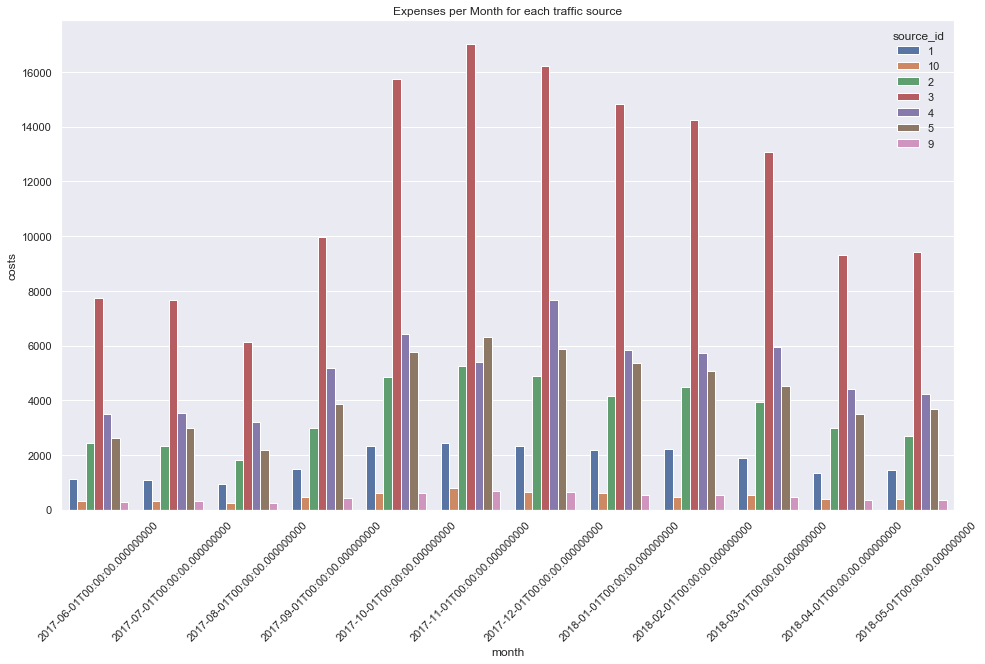

In [71]:
fig,ax=plt.subplots()
fig.set_size_inches(16,9)
g=sns.barplot(data=monthly_expenses,x='month',y='costs',hue='source_id')
g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.title('Expenses per Month for each traffic source')
plt.show()

* The pattern between each traffic source expenses through the months remain similar with leading mainly the expenses the source 3 and following 1,5,2. Only in 2017-11-01 the we spend more for the traffic source 5 than the 4.

In [72]:
#customer acquisition cost, CAC
expenses['cohort']=expenses['dt'].apply(lambda x: x.strftime('%Y-%m'))
display(expenses.head(2))

#expenses by cohort
cohort_expenses=expenses.groupby('cohort')['costs'].sum().reset_index().rename(columns={'costs':'expenses_by_cohort'})

expenses_report= expenses.merge(cohort_expenses,on='cohort')
display(expenses_report.head(2))

#expenses by cohort for each traffic source
cohort_expenses_source=expenses.groupby(['cohort','source_id'])\
['costs'].sum().reset_index().rename(columns={'costs':'cohort_expenses_by_source'})
expenses_report=expenses_report.merge(cohort_expenses_source,on=['cohort','source_id'])
display(expenses_report.head(3))


,source_id,dt,costs,month,cohort
0,1,2017-06-01,75.199997,2017-06-01,2017-06
1,1,2017-06-02,62.250000,2017-06-01,2017-06


,source_id,dt,costs,month,cohort,expenses_by_cohort
0,1,2017-06-01,75.199997,2017-06-01,2017-06,18015.0
1,1,2017-06-02,62.250000,2017-06-01,2017-06,18015.0


,source_id,dt,costs,month,cohort,expenses_by_cohort,cohort_expenses_by_source
0,1,2017-06-01,75.199997,2017-06-01,2017-06,18015.0,1125.609985
1,1,2017-06-02,62.250000,2017-06-01,2017-06,18015.0,1125.609985
2,1,2017-06-03,36.529999,2017-06-01,2017-06,18015.0,1125.609985


In [73]:
conv_traffic.head()

,buy_ts,uid,start_ts,source_id,1st_visit,first_traffic,1st_buy,conv_traffic,conv_days,cohort_traffic
0,2017-06-01 00:10:00,10329302124590727494,2017-06-01 00:09:00,1,2017-06-01 00:09:00,1,2017-06-01 00:10:00,1,0,2017-06
1,2017-06-01 00:25:00,11627257723692907447,2017-06-01 00:14:00,2,2017-06-01 00:14:00,2,2017-06-01 00:25:00,2,0,2017-06
2,2017-06-01 00:29:00,16109239769442553005,2017-06-01 00:14:00,2,2017-06-01 00:14:00,2,2017-06-01 00:29:00,2,0,2017-06
3,2017-06-01 00:27:00,17903680561304213844,2017-06-01 00:25:00,2,2017-06-01 00:25:00,2,2017-06-01 00:27:00,2,0,2017-06
4,2017-07-21 14:56:00,16945437833757229838,2017-06-01 01:18:00,2,2017-06-01 01:18:00,2,2017-07-21 14:56:00,3,51,2017-06


In [74]:
cust_traffic=conv_traffic.groupby(['cohort_traffic','conv_traffic'])\
['uid'].nunique().reset_index().rename(columns={'uid':'customers_per_source'})

cohort_expenses_source=cohort_expenses_source.\
merge(cust_traffic,left_on=['cohort','source_id'],right_on=['cohort_traffic','conv_traffic'],how='inner')

cohort_expenses_source.head()

,cohort,source_id,cohort_expenses_by_source,cohort_traffic,conv_traffic,customers_per_source
0,2017-06,1,1125.609985,2017-06,1,311
1,2017-06,10,314.220001,2017-06,10,98
2,2017-06,2,2427.379883,2017-06,2,451
3,2017-06,3,7731.649902,2017-06,3,781
4,2017-06,4,3514.800049,2017-06,4,622


In [75]:
#customer acquisition per customer per source
cohort_expenses_source['cac_by_source']=cohort_expenses_source['cohort_expenses_by_source']/\
cohort_expenses_source['customers_per_source']
cohort_expenses_source['mean_cac']=cohort_expenses_source['cac_by_source'].mean()
display(cohort_expenses_source.head(2))

cac_report=cohort_expenses_source[['cohort','source_id',\
                                   'cohort_expenses_by_source','customers_per_source',\
                                   'cac_by_source','mean_cac']]
display(cac_report.head(3))

,cohort,source_id,cohort_expenses_by_source,cohort_traffic,conv_traffic,customers_per_source,cac_by_source,mean_cac
0,2017-06,1,1125.609985,2017-06,1,311,3.619325,8.162474
1,2017-06,10,314.220001,2017-06,10,98,3.206327,8.162474


,cohort,source_id,cohort_expenses_by_source,customers_per_source,cac_by_source,mean_cac
0,2017-06,1,1125.609985,311,3.619325,8.162474
1,2017-06,10,314.220001,98,3.206327,8.162474
2,2017-06,2,2427.379883,451,5.382217,8.162474


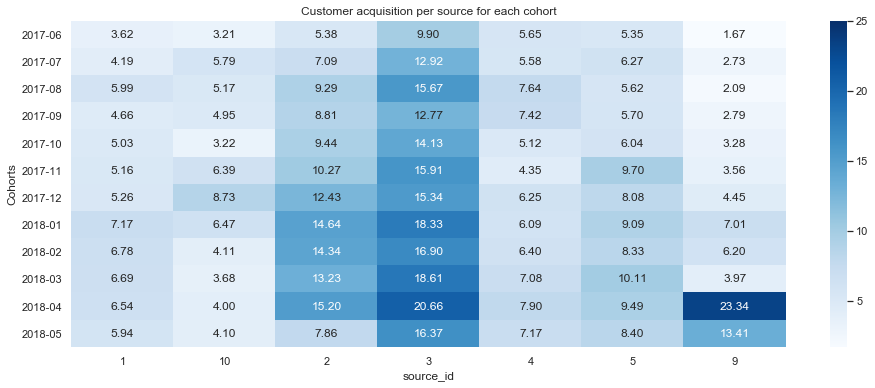

In [76]:
#customer acquisition per source for each cohort
cohort_cac_source=cac_report.pivot_table(index='cohort',\
                                         values='cac_by_source',columns='source_id',\
                                        aggfunc='mean')


plt.figure(figsize=(16,6))
sns.heatmap(data=cohort_cac_source,fmt='.2f',cmap='Blues',annot=True,vmax=25)
plt.ylabel('Cohorts')
plt.title('Customer acquisition per source for each cohort')
plt.show()

* The most expensive customer acquisition is been found comes from cohort 2018-04 and traffic source 9 while the most affortable comes again from source 9 but from cohort 2017-06

In [77]:
#mean customer acquisition from each of the sources cost 
cac_report.groupby('source_id')['cac_by_source'].mean().sort_values()

source_id
10     4.984004
1      5.586361
9      6.207741
4      6.386817
5      7.681078
2     10.665529
3     15.625786
Name: cac_by_source, dtype: float64

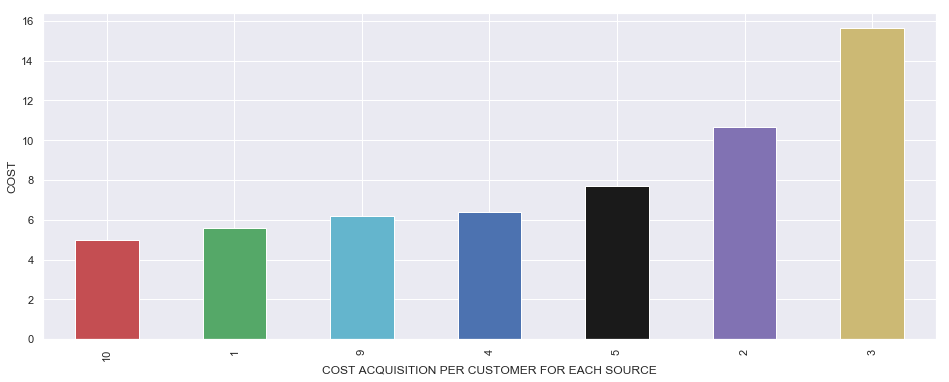

In [78]:
cac_report.groupby('source_id')\
['cac_by_source'].mean().sort_values()\
.plot(kind='bar',figsize=(16,6),color=('r','g','c','b','k','m','y','w'))
plt.ylabel('COST')
plt.xlabel('COST ACQUISITION PER CUSTOMER FOR EACH SOURCE')
plt.show()

* 1,2,5 sources are the top 3 convesion sources but only the source 1(second best in conversion source) spots in the second cheapest customer acquision source.

In [79]:
orders_per_cohort.head()

,cohort_conv_month,total_transactions,total_revenue,number_of_customers,mean_purchase,revenue_user
0,2017-06,4438,24031.689453,2023,5.414982,11.879234
1,2017-07,2910,16127.919922,1923,5.542241,8.386854
2,2017-08,2188,11606.259766,1370,5.304506,8.471722
3,2017-09,3878,34676.320312,2581,8.941805,13.435227
4,2017-10,6005,27603.449219,4340,4.596744,6.360242


In [80]:
#calculate overall ROMI( return of marketing investment), for the whole time period we have data
romi=orders_per_cohort['total_revenue'].sum()/cac_report['cohort_expenses_by_source'].sum()
romi

0.765825

* Since the overall ROMI is below 1 that means the company hasn't taken back its marketing investment so far.

In [81]:
#monthly customer acquisition per cohort
cac_month=expenses.groupby(['cohort','month'])['costs']\
.sum().reset_index().rename(columns={'costs':'cohort_expenses'})
display(cac_month.head(2))


display(orders.head(2))
cac_df=cac_month[['cohort','cohort_expenses']]\
.merge(orders,left_on='cohort',right_on='cohort_conv_month')
cac_df.head(2)

,cohort,month,cohort_expenses
0,2017-06,2017-06-01,18015.000000
1,2017-07,2017-07-01,18240.589844


,buy_ts,revenue,uid,first_act,first_buy,cohort_conv_month,conv_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01 00:10:00,2017-06,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01 00:25:00,2017-06,0


,cohort,cohort_expenses,buy_ts,revenue,uid,first_act,first_buy,cohort_conv_month,conv_lifetime
0,2017-06,18015.0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01 00:10:00,2017-06,0
1,2017-06,18015.0,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01 00:25:00,2017-06,0


In [82]:
#initial number of customers of each cohort
customers=cac_df.groupby('cohort')['uid']\
.nunique().reset_index().rename(columns={'uid':'customers'})
cac_df=cac_df.merge(customers,on='cohort')
cac_df['cac']=cac_df['cohort_expenses']/cac_df['customers']
cac_df.head(2)

,cohort,cohort_expenses,buy_ts,revenue,uid,first_act,first_buy,cohort_conv_month,conv_lifetime,customers,cac
0,2017-06,18015.0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:09:00,2017-06-01 00:10:00,2017-06,0,2023,8.905091
1,2017-06,18015.0,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:14:00,2017-06-01 00:25:00,2017-06,0,2023,8.905091


In [83]:
cac_pivot=cac_df.pivot_table(index='cohort',values='cac'\
                             ,columns='conv_lifetime',aggfunc='mean')
cac_pivot

conv_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
cohort,,,,,,,,,,,,
2017-06,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091,8.905091
2017-07,9.485486,9.485486,9.485486,9.485486,9.485486,9.485486,9.485486,9.485486,9.485486,9.485486,9.485486,NaN
2017-08,10.796015,10.796015,10.796015,10.796015,10.796015,10.796015,10.796015,10.796015,10.796015,10.796015,NaN,NaN
2017-09,9.441654,9.441654,9.441654,9.441654,9.441654,9.441654,9.441654,9.441654,9.441654,NaN,NaN,NaN
2017-10,8.369327,8.369327,8.369327,8.369327,8.369327,8.369327,8.369327,8.369327,NaN,NaN,NaN,NaN
2017-11,9.288870,9.288870,9.288870,9.288870,9.288870,9.288870,9.288870,NaN,NaN,NaN,NaN,NaN
2017-12,8.741810,8.741810,8.741810,8.741810,8.741810,8.741810,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,9.937302,9.937302,9.937302,9.937302,9.937302,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,8.962758,8.962758,8.962758,8.962758,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


conv_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
2017-06,0.552153,0.597611,0.650838,0.783194,0.873664,0.980463,1.057166,1.129499,1.190524,1.255411,1.311357,1.333982
2017-07,0.653306,0.686315,0.758404,0.776958,0.795327,0.810033,0.824059,0.844162,0.853622,0.871534,0.884178,NaN
2017-08,0.519165,0.560271,0.604755,0.643168,0.676415,0.699985,0.723083,0.761765,0.777805,0.784708,NaN,NaN
2017-09,0.669084,0.749761,1.138705,1.220590,1.290155,1.347599,1.390822,1.406093,1.422974,NaN,NaN,NaN
2017-10,0.638513,0.673571,0.694111,0.714984,0.729345,0.738698,0.751668,0.759947,NaN,NaN,NaN,NaN
2017-11,0.581518,0.608102,0.637335,0.667137,0.673884,0.681468,0.688485,NaN,NaN,NaN,NaN,NaN
2017-12,0.555706,0.601348,0.738927,0.803536,0.868717,0.873951,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,0.439803,0.465581,0.487815,0.494519,0.497132,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,0.485290,0.498857,0.508075,0.511887,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03,0.591548,0.613945,0.633675,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


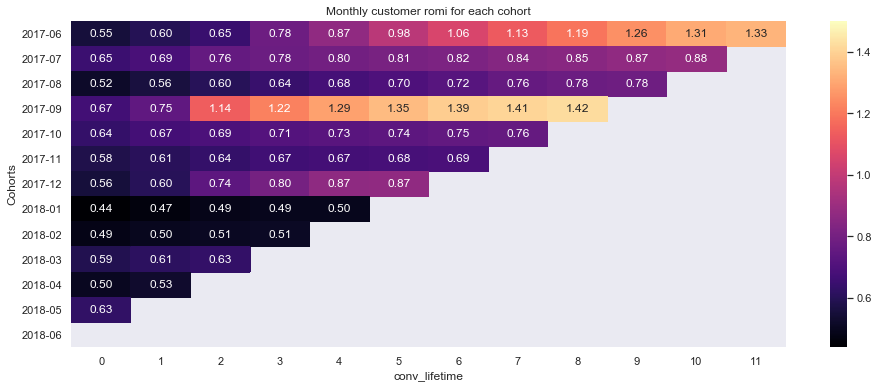

In [84]:
#calculate the monthly return of investment per user for each cohort
romi_customer=ltv_user/cac_pivot
display(romi_customer)

plt.figure(figsize=(16,6))
sns.heatmap(data=romi_customer,fmt='.2f',cmap='magma',annot=True,vmax=1.5)
plt.ylabel('Cohorts')
plt.title('Monthly customer romi for each cohort')
plt.show()

* we see only the cohort 2017-06 started to pay off the investment on 7th month and the 2017-09 which performs much better started to be profitable on the 3rd month.
* None of the rest cohorts have turned positive in terms of investment but all have an increasing trend which means probably soon will turn also these to profitable.
* Marketing seems to bee efficient but  we should give some more time to the business to flourish.

> * Following we will find now the romi for the source of the first visit, not from the first purchase.
We know that some users return from a different source and proceeded to the first purchase but is important to calculate the costs of the source that attracted for the first time a user and prompt him to become a customer.

In [85]:
ordersf=orders[['buy_ts','revenue','uid']]
visitsf=visits[['end_ts','source_id','start_ts','uid']]
expensesf=expenses[['source_id','dt','costs','month']]

In [86]:
#find the first source
first_source=visitsf.sort_values('start_ts').groupby('uid',as_index=False)\
.agg({'source_id':'first'}).rename(columns={'source_id':'first_source'})

first_source.head()

,uid,first_source
0,11863502262781,3
1,49537067089222,2
2,297729379853735,3
3,313578113262317,2
4,325320750514679,5


In [87]:
first_source=ordersf.merge(first_source,on='uid',how='left')
first_source.head()

,buy_ts,revenue,uid,first_source
0,2017-06-01 00:10:00,17.00,10329302124590727494,1
1,2017-06-01 00:25:00,0.55,11627257723692907447,2
2,2017-06-01 00:27:00,0.37,17903680561304213844,2
3,2017-06-01 00:29:00,0.55,16109239769442553005,2
4,2017-06-01 07:58:00,0.37,14200605875248379450,3


In [88]:
first_source['month']=first_source['buy_ts'].astype('datetime64[M]')

first_source_rev=first_source.groupby(['first_source','month'])\
.agg({'revenue':'sum','uid':'nunique'}).reset_index()\
.rename(columns={'revenue':'total_rev','uid':'n_buyers'})

first_source_rev['per_buyer']=first_source_rev['total_rev']/first_source_rev['n_buyers']
first_source_rev.head()

,first_source,month,total_rev,n_buyers,per_buyer
0,1,2017-06-01,1378.699951,190,7.256316
1,1,2017-07-01,1581.680054,176,8.986818
2,1,2017-08-01,1441.489990,128,11.261641
3,1,2017-09-01,3071.610107,255,12.045530
4,1,2017-10-01,3621.820068,376,9.632500


In [89]:
#ltv per customer of each first visit source
ltv_source=first_source_rev.pivot_table(index='first_source'\
                                        ,values='per_buyer',columns='month'\
                                        ,aggfunc='mean').cumsum(axis=1)
ltv_source

month,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00,2018-06-01 00:00:00
first_source,,,,,,,,,,,,,
1,7.256316,16.243134,27.504775,39.550304,49.182805,58.372047,65.455475,74.174998,81.299513,92.350140,103.081017,111.211571,NaN
10,2.414211,5.953644,10.735439,12.965894,15.629708,20.193338,23.851338,26.958787,29.483414,32.898037,35.326003,38.860688,NaN
2,4.441192,13.093553,19.777150,29.341356,40.874523,50.175128,60.158233,68.304425,85.269541,103.458024,115.250120,125.603645,NaN
3,4.395517,10.486546,15.826138,21.528550,26.484165,31.423882,35.581791,39.755260,43.759402,48.341172,52.920876,57.914445,NaN
4,4.745375,10.247837,15.369532,20.394961,25.264540,30.907818,35.817309,39.664094,44.179735,49.662176,55.398678,60.315573,63.735573
5,4.945026,10.855644,16.539441,23.736868,29.307814,34.459925,51.292577,56.795119,63.284581,69.258106,74.059869,78.526401,NaN
7,NaN,NaN,1.220000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3.568971,8.045763,12.346777,16.811535,21.871035,25.808386,30.170869,33.470438,38.136164,41.441823,46.068489,50.661904,NaN


In [90]:
#calculate the costs per first visit source per month per buyer
source_costs=expensesf.groupby(['source_id','month']).agg({'costs':'sum'}).reset_index()\
.rename(columns={'costs':'monthly_costs'})
source_costs.head()

source_costs_buyer=source_costs.merge(first_source_rev[['first_source','month','n_buyers']],\
                                     left_on=['source_id','month'],right_on=['first_source',\
                                                                            'month'])
source_costs_buyer.head()

,source_id,month,monthly_costs,first_source,n_buyers
0,1,2017-06-01,1125.609985,1,190
1,1,2017-07-01,1072.880005,1,176
2,1,2017-08-01,951.809998,1,128
3,1,2017-09-01,1502.010010,1,255
4,1,2017-10-01,2315.750000,1,376


In [91]:
source_costs_buyer['costs_buyer']=source_costs_buyer['monthly_costs']/\
source_costs_buyer['n_buyers']
source_costs_buyer.head()

,source_id,month,monthly_costs,first_source,n_buyers,costs_buyer
0,1,2017-06-01,1125.609985,1,190,5.924263
1,1,2017-07-01,1072.880005,1,176,6.095909
2,1,2017-08-01,951.809998,1,128,7.436016
3,1,2017-09-01,1502.010010,1,255,5.890235
4,1,2017-10-01,2315.750000,1,376,6.158910


In [92]:
#find the cac for each source
source_cac=source_costs_buyer.pivot_table(index='source_id',values='costs_buyer',\
                                         columns='month',aggfunc='mean').cumsum(axis=1)
source_cac

month,2017-06-01 00:00:00,2017-07-01 00:00:00,2017-08-01 00:00:00,2017-09-01 00:00:00,2017-10-01 00:00:00,2017-11-01 00:00:00,2017-12-01 00:00:00,2018-01-01 00:00:00,2018-02-01 00:00:00,2018-03-01 00:00:00,2018-04-01 00:00:00,2018-05-01 00:00:00
source_id,,,,,,,,,,,,
1,5.924263,12.020172,19.456188,25.346423,31.505333,37.889562,43.923583,51.384948,58.065190,63.458609,69.280933,74.061422
10,3.307579,9.530598,15.493931,20.728818,23.646213,29.515546,36.314072,42.582950,46.171607,48.816883,52.107138,54.973291
2,10.329276,21.130712,34.159849,46.007706,56.517467,67.097467,77.585261,88.976331,100.537932,109.602622,119.890250,125.247700
3,12.118574,26.736421,43.430824,55.626111,68.358506,81.354949,92.510052,105.615167,117.034557,128.610530,141.106243,150.593562
4,8.510412,15.246538,24.335126,32.750458,37.957952,42.214524,47.224615,52.184471,56.728592,61.548212,67.017802,71.467865
5,6.812813,13.673545,19.516540,25.744921,31.547134,39.740580,46.601000,54.061445,60.563124,67.822131,74.996619,81.423169
9,4.194412,9.902714,13.510395,17.545540,21.354353,25.047218,29.463191,34.180087,38.627668,40.970546,46.383444,50.800152


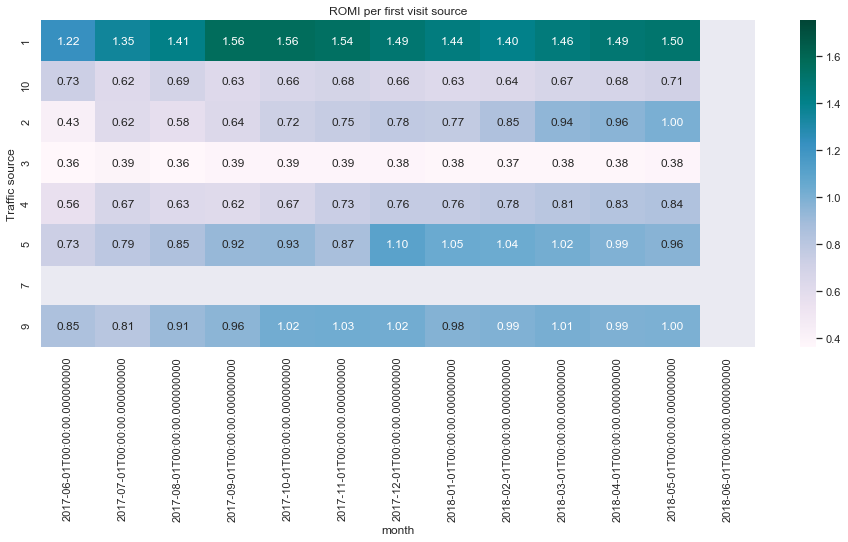

In [93]:
#find romi per first visit source per month
source_romi=ltv_source/source_cac
source_romi

plt.figure(figsize=(16,6))
sns.heatmap(data=source_romi,fmt='.2f',cmap='PuBuGn',annot=True,vmax=1.75)
plt.ylabel('Traffic source')
plt.title('ROMI per first visit source')
plt.show()

* Source 1 is the most efficient from the first month.In second place comes source 9 which pays off from the 5th month.
* Besides sources 1 and 9 , good signs have shown the sources 2 & 5, with the source 5th being profitable for 4 months while source 2 only for the last but had a constant upwards behaviour the whole time period till to pay off its costs.

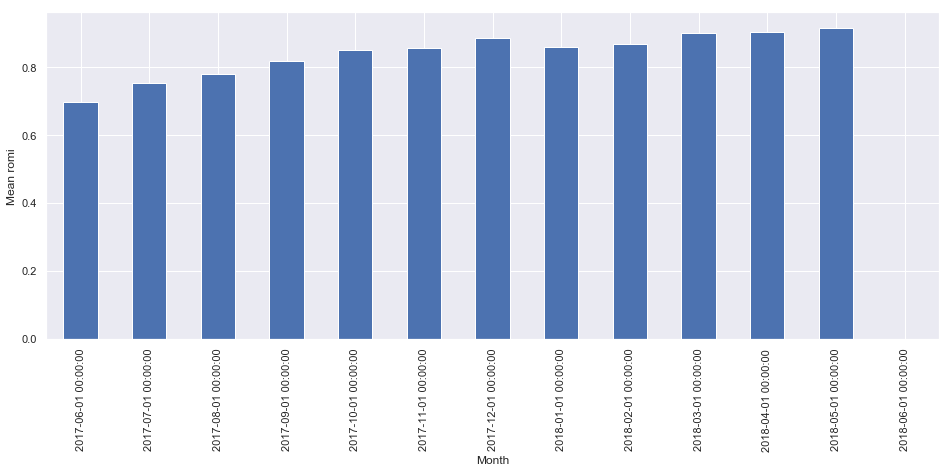

In [94]:
#mean romi for all sources for each month
source_romi.mean().plot(kind='bar',figsize=(16,6))
plt.ylabel('Mean romi')
plt.xlabel('Month')
plt.show()

* In none of the months the mean romi of all sources reaches the investment(=1). Hence in general the enterprise is not yet profitable 

* **Conclusions-Summary-Suggestions**
> * We saw sources 1,2,5 to perform better than the others in pay off a part of the marketing investment.
* We see only the cohort 2017-06 started to pay off the investment on 7th month and the 2017-09 which performs much better started to be profitable on the 3rd month.
* None of the rest cohorts have turned positive in terms of investment but all have an increasing trend which means probably soon will turn also these to profitable.
* Marketing seems to be efficient but  we should give some more time to the business to flourish. 
* The traffic source 3,4 have the highest costs for the company and they don't perform well in return the invested money. Maybe moving out them could help the company reducing its expenses by 61%.
* The winter months 2017-09:2017-12 were the most active with the higher lifetime value(revenue) for its cohorts.
* Traffic sources 2,4 have loyal first visitors that made their first purchase from the same traffic source
* We have more desktop users that spend more time in each session than the touch users.
* Sources 3,4 have the most active users daily although they don't pay off their costs.
* 1,2,5 sources are the top 3 convesion sources but only the source 1(second best in conversion source) spots in the second cheapest customer acquision source.
* On 2017-11-24	the source 3 had a drastic pick(the most active source) with 932 active users having 794 desktop users and 171 touch users. We should take a closer look to this traffic source and see why perfomed better that day and if can we get any deeper insight or was a random event.
* On 2018-03-31 we had a drastic drop in activity. That could be related to a tragic event, a fire on a shopping mall,  that took place some days before on  25 March 2018 https://en.wikipedia.org/wiki/2018_Kemerovo_fire.
* The majority of the users use desktop with a population of 164523 over 71345 which use a touch device out of a total 235868 devices
* The average session is 60 sec
* The most expensive customer acquisition comes from the cohort 2018-04 and traffic source 9 while the most affortable comes again from source 9 but from cohort 2017-06
* 2455 users out of 228169 of total users made a purchase on their registration day
* Since the overall ROMI is below 1(0,76) that means the company hasn't taken back its marketing investment so far.
* Source 1 is the most efficient,with romi>1 from the first month.In second place comes source 9 which pays off from the 5th month.
Besides sources 1 and 9 , good signs have shown the sources 2 & 5, with the source 5th being profitable for 4 months while source 2 only for the last but had a constant upwards behaviour the whole time period till to pay off its costs.
* For the whole of our data the Average purchase size is 4.92\\$ while the Total number of orders is 50415
* The Average purchase size for the year 2017 is 5.12\\$ with total number of transcations:27467
* Average purchase size for the year 2018 is 4.85\\$ out of 22948 total number of transcations

